# Data Processing
## Computational Methods in Psychology and Neuroscience
### Psychology 4215/7215 --- Fall 2023
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. Read data from slog files
2. The Series and DataFrame data structures in Pandas
3. Load slogs as a DataFrame
4. Some basic operations on the data


# Updating SMILE

- First you can test whether there is a new version Kivy, which is the primary dependency of SMILE:

```bash
conda install -c conda-forge kivy
```

- Then you can update SMILE right from the GitHub repository (note the upgrade option at the end):

```bash
pip install git+https://github.com/compmem/smile --upgrade
```

# Math Distract

- Sometimes you want to have a delay period, e.g., between study and test
- Although it may be fine to have an empty delay, often you'd like to fill it with a task that prevents rehearsal of the studied items
- We provide a subroutine that generates math problems!

In [19]:
from smile.common import *
from smile.math_distract import MathDistract

exp = Experiment(show_splash=False, resolution=(1024,768))

Wait(1.0)
MathDistract(num_vars=3,
             min_num=1,
             max_num=9,
             max_probs=50,
             duration=20)
    
exp.run()

# Moving Dot stimuli

- A class of stimuli at the core of many studies of perceptual decision-making
- We provide a custom state for it:

In [2]:
from smile.common import *
from smile.moving_dots import MovingDots

exp = Experiment(show_splash=False, resolution=(1024,768))

# set up some config
dot_speed = 180

# set initial values
exp.cr=0.2
exp.cl=0.2
motion_props = [{"coherence": exp.cr, "direction": 0, "direction_variance": 0},
                {"coherence": exp.cl, "direction": 180, "direction_variance": 0}]
with Loop():
    with Parallel():
        dots = MovingDots(color='white', scale=3, num_dots=100, radius=200,
                                motion_props=motion_props, speed=dot_speed,
                                lifespan=0.5, lifespan_variance=1.5)
        lr = Label(text=Ref.object('Right Coherence:\n{:.2f}').format(exp.cr), 
                   left=dots.right+40, font_size=28) 
        ll = Label(text=Ref.object('Left Coherence:\n{:.2f}').format(exp.cl), 
                   right=dots.left-40, font_size=28)

    with UntilDone():
            kp = KeyPress(keys=['UP','DOWN','LEFT','RIGHT'])
            with If(kp.pressed=='UP'):
                exp.cr=exp.cr+0.05
                exp.cl=exp.cl+0.05
                with If(exp.cr+exp.cl>1.0):
                    exp.cr=exp.cr-0.05
                    exp.cl=exp.cl-0.05
            with Elif((kp.pressed=='DOWN')):
                exp.cr=exp.cr-0.05
                exp.cl=exp.cl-0.05
                with If(exp.cr<0.05):
                    exp.cr=0.0
                with If(exp.cl<0.05):
                    exp.cl=0.0
            with Elif(kp.pressed=='LEFT'):
                exp.cl=exp.cl+0.05
                with If(exp.cr+exp.cl>1.0):
                    exp.cl=exp.cl-0.05
            with Elif(kp.pressed=='RIGHT'):
                exp.cr=exp.cr+0.05
                with If(exp.cr+exp.cl>1.0):
                    exp.cr=exp.cr-0.05
            # update the motion props
            dots.update(motion_props=[{"coherence": exp.cr, "direction": 0},
                                      {"coherence": exp.cl, "direction": 180}])
            lr.update(text=Ref.object('Right Coherence:\n{:.2f}').format(exp.cr))
            ll.update(text=Ref.object('Left Coherence:\n{:.2f}').format(exp.cl))
with UntilDone():
    KeyPress(keys=['ENTER'])

    
exp.run()

# Reading in slog files

- SMILE stores data in log files with the `.slog` file extension
- It is a custom format that are pickled and compressed dictionaries
- We can read them in with a SMILE function `log2dl` that converts the log to a list of dictionaries (i.e., a dict list):

In [17]:
from smile.log import log2dl
dl = log2dl('log_MD_0.slog')
dl[:2]

[{'rt': 2.941615221919392,
  'disappear_time_error': 0.0,
  'disappear_time_time': 617.657840390051,
  'run_num': 0,
  'refresh_rate': 26.731467774154293,
  'appear_time_error': 0.0,
  'appear_time_time': 614.7072808193332,
  'eeg_pulse_time': None,
  'right_coherence': 0.06,
  'left_coherence': 0.0,
  'press_time_error': 0.0005104763318968253,
  'press_time_time': 617.6488960412526,
  'incorrect_resp': '1',
  'pressed': '1',
  'log_time': 618.1488960412526,
  'correct_resp': '4',
  'correct': False,
  'fmri_tr_time': None,
  'log_num': 0},
 {'rt': 1.5730700115865375,
  'disappear_time_error': 0.0,
  'disappear_time_time': 620.2500236883183,
  'run_num': 0,
  'refresh_rate': 26.59035375261749,
  'appear_time_error': 0.0,
  'appear_time_time': 618.6663967214259,
  'eeg_pulse_time': None,
  'right_coherence': 0.24,
  'left_coherence': 0.3,
  'press_time_error': 0.00047487459045214564,
  'press_time_time': 620.2394667330125,
  'incorrect_resp': '4',
  'pressed': '4',
  'log_time': 620.739

# Pandas

- Library at the core of most data science with Python
- Provides two key data structures: `Series` and `DataFrame`
- The key feature of Pandas is that ***data alignment is intrinsic***. 
  - The link between labels and data will not be broken unless done so explicitly by you.


## Series

- A `Series` is a one-dimensional labeled array capable of holding any data type:
  - integers, strings, floating point numbers, Python objects, etc...
- The axis labels are collectively referred to as the index. 

In [3]:
import pandas as pd
import numpy as np

s = pd.Series(np.random.randn(5))
s

0    0.065871
1    2.134110
2   -1.492454
3   -0.201191
4   -0.572541
dtype: float64

In [4]:
# you can specify the index
s = pd.Series(np.random.randn(5), index=['a', 'b', 'c', 'd', 'e'])
s

a    1.146421
b   -0.309947
c   -0.862864
d    1.096532
e   -1.431422
dtype: float64

## Series are ndarray-like

- You can slice a series and it will also slice your index
- And many of the same methods are available (e.g., mean, sum, etc...)


In [5]:
s[2:]

c   -0.862864
d    1.096532
e   -1.431422
dtype: float64

In [6]:
s.mean()

-0.07225605972307125

In [7]:
s[s > s.mean()]

a    1.146421
d    1.096532
dtype: float64

In [8]:
s > s.mean()

a     True
b    False
c    False
d     True
e    False
dtype: bool

## Series is also dict-like

- A Series is like a fixed-size dict in that you can get and set values by index label

In [9]:
s['d']

1.096532092339073

In [10]:
'd' in s

True

## Series keeps array operations aligned

- Series can also be passed into most NumPy methods expecting an ndarray.
- Alignment will be maintained

In [11]:
s+s

a    2.292842
b   -0.619895
c   -1.725728
d    2.193064
e   -2.862845
dtype: float64

In [12]:
np.mean(s)

-0.07225605972307125

In [13]:
np.exp(s)

a    3.146910
b    0.733486
c    0.421952
d    2.993766
e    0.238969
dtype: float64

In [14]:
s[1:] + s[:-1]

a         NaN
b   -0.619895
c   -1.725728
d    2.193064
e         NaN
dtype: float64

In [60]:
x = pd.Series(np.random.randn(5)*10)
x.astype(np.int)

0     0
1   -16
2    16
3     3
4    16
dtype: int64

## DataFrame

- `DataFrame` is a 2-dimensional labeled data structure with columns of potentially different types. 
- You can think of it like a spreadsheet or SQL table, or a dict of `Series` objects.
- It's possible to create a DataFrame a lot of different ways.

In [44]:
# e.g., from a dictionary
d = {'one': [1., 2., 3., 4.],
     'two': [4., 3., 2., 1.]}
df = pd.DataFrame(d, index=['a', 'b', 'c', 'd'])
df

,one,two
a,1.0,4.0
b,2.0,3.0
c,3.0,2.0
d,4.0,1.0


## Column selection, addition, deletion

- You can treat a DataFrame like a dict of Series objects

In [45]:
# pick a column
df['one']

a    1.0
b    2.0
c    3.0
d    4.0
Name: one, dtype: float64

In [46]:
# make new columns
df['three'] = df['one'] + df['two']
df['thresh'] = df['one'] > 2.0
df

,one,two,three,thresh
a,1.0,4.0,5.0,False
b,2.0,3.0,5.0,False
c,3.0,2.0,5.0,True
d,4.0,1.0,5.0,True


In [47]:
df.dtypes

one       float64
two       float64
three     float64
thresh       bool
dtype: object

In [48]:
# you can make copies with the copy method
df2 = df.copy()

In [49]:
# you can delete with del or pop
del df['two']
df.pop('three')
df

,one,thresh
a,1.0,False
b,2.0,False
c,3.0,True
d,4.0,True


In [50]:
# df2 should be untouched
df2

,one,two,three,thresh
a,1.0,4.0,5.0,False
b,2.0,3.0,5.0,False
c,3.0,2.0,5.0,True
d,4.0,1.0,5.0,True


In [51]:
# copy it back to retrieve the deleted columns
df = df2.copy()

In [52]:
# new values will populate the entire column
df['foo'] = 'bar'
df

,one,two,three,thresh,foo
a,1.0,4.0,5.0,False,bar
b,2.0,3.0,5.0,False,bar
c,3.0,2.0,5.0,True,bar
d,4.0,1.0,5.0,True,bar


## Indexing and Selection

  - loc
  - iloc
  - boolean
  - column


In [53]:
df.loc[df['one']>2]

,one,two,three,thresh,foo
c,3.0,2.0,5.0,True,bar
d,4.0,1.0,5.0,True,bar


In [54]:
df

,one,two,three,thresh,foo
a,1.0,4.0,5.0,False,bar
b,2.0,3.0,5.0,False,bar
c,3.0,2.0,5.0,True,bar
d,4.0,1.0,5.0,True,bar


In [55]:
# pick columns of interest
df[['one', 'thresh']]

,one,thresh
a,1.0,False
b,2.0,False
c,3.0,True
d,4.0,True


In [56]:
# pick rows by index
df.loc[['b', 'c']]

,one,two,three,thresh,foo
b,2.0,3.0,5.0,False,bar
c,3.0,2.0,5.0,True,bar


In [57]:
# pick rows by numeric index
df.iloc[[1, 3]]

,one,two,three,thresh,foo
b,2.0,3.0,5.0,False,bar
d,4.0,1.0,5.0,True,bar


In [59]:
# pick rows by boolean index
df2 = df[(df['two']>2) & (df['one']<=1)]
df2

,one,two,three,thresh,foo
a,1.0,4.0,5.0,False,bar


In [61]:
# pick rows (and specific columns) by boolean index
df3 = df.loc[(df['two']>2) & (df['one']<=1), ['two', 'three']]
df3

,two,three
a,4.0,5.0


## SMILE and Pandas

- We can create a DataFrame from a dict list in SMILE:

In [62]:
dl = log2dl('log_MD_0.slog')
df = pd.DataFrame(dl)
df.head(5)

,rt,disappear_time_error,disappear_time_time,run_num,refresh_rate,appear_time_error,appear_time_time,eeg_pulse_time,right_coherence,left_coherence,press_time_error,press_time_time,incorrect_resp,pressed,log_time,correct_resp,correct,fmri_tr_time,log_num
0,2.941615,0.0,617.657840,0,26.731468,0.0,614.707281,None,0.06,0.00,0.000510,617.648896,1,1,618.148896,4,False,None,0
1,1.573070,0.0,620.250024,0,26.590354,0.0,618.666397,None,0.24,0.30,0.000475,620.239467,4,4,620.739467,1,False,None,0
2,2.810989,0.0,624.100785,0,27.489738,0.0,621.275211,None,0.00,0.00,0.000544,624.086200,1,4,624.586200,4,True,None,0
3,0.872496,0.0,625.751111,0,27.255089,0.0,624.850929,None,0.00,0.24,0.001483,625.723425,4,1,626.223425,1,True,None,0
4,1.818831,0.0,628.618369,0,26.489366,0.0,626.784654,None,0.00,0.12,0.000755,628.603485,4,1,629.103485,1,True,None,0


# A quick summary

- You can use the `describe` method to get a quick summary of your data frame

In [63]:
df.describe()

,rt,disappear_time_error,disappear_time_time,run_num,refresh_rate,appear_time_error,appear_time_time,right_coherence,left_coherence,press_time_error,press_time_time,log_time,log_num
count,248.000000,248.0,248.000000,248.000000,248.000000,248.0,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.0
mean,0.804588,0.0,1481.126965,1.500000,26.667593,0.0,1480.307270,0.150000,0.150000,0.001204,1481.111858,1481.611858,0.0
std,0.383854,0.0,601.187932,1.120295,0.854239,0.0,601.233562,0.104552,0.104552,0.005860,601.187790,601.187790,0.0
min,0.252737,0.0,617.657840,0.000000,21.059205,0.0,614.707281,0.000000,0.000000,0.000430,617.648896,618.148896,0.0
25%,0.558839,0.0,1008.340282,0.750000,26.397669,0.0,1007.321325,0.060000,0.060000,0.000497,1008.328116,1008.828116,0.0
50%,0.678502,0.0,1532.049636,1.500000,26.717780,0.0,1530.628267,0.150000,0.150000,0.000519,1532.033580,1532.533580,0.0
75%,0.926857,0.0,2005.156651,2.250000,27.143314,0.0,2004.558631,0.240000,0.240000,0.000547,2005.143065,2005.643065,0.0
max,2.941615,0.0,2243.141804,3.000000,28.609071,0.0,2241.983237,0.300000,0.300000,0.069283,2243.130664,2243.630664,0.0


# Some data clean-up

In [64]:
df.columns

Index(['rt', 'disappear_time_error', 'disappear_time_time', 'run_num',
       'refresh_rate', 'appear_time_error', 'appear_time_time',
       'eeg_pulse_time', 'right_coherence', 'left_coherence',
       'press_time_error', 'press_time_time', 'incorrect_resp', 'pressed',
       'log_time', 'correct_resp', 'correct', 'fmri_tr_time', 'log_num'],
      dtype='object')

In [65]:
# let's add a new column for the absolute value of the coherence difference
df['coh_diff'] = np.abs(df['right_coherence'] - df['left_coherence'])

# and make a log rt
df['log_rt'] = np.log(df['rt'])

df['trial_num'] = np.arange(len(df))

df = df[['run_num', 'trial_num', 'rt', 'log_rt', 'coh_diff',   
         'right_coherence', 'left_coherence', 'appear_time_time',
         'press_time_error', 'press_time_time', 'incorrect_resp', 'pressed',
         'correct_resp', 'correct']]

# show it
df.head()

,run_num,trial_num,rt,log_rt,coh_diff,right_coherence,left_coherence,appear_time_time,press_time_error,press_time_time,incorrect_resp,pressed,correct_resp,correct
0,0,0,2.941615,1.078959,0.06,0.06,0.00,614.707281,0.000510,617.648896,1,1,4,False
1,0,1,1.573070,0.453029,0.06,0.24,0.30,618.666397,0.000475,620.239467,4,4,1,False
2,0,2,2.810989,1.033537,0.00,0.00,0.00,621.275211,0.000544,624.086200,1,4,4,True
3,0,3,0.872496,-0.136397,0.24,0.00,0.24,624.850929,0.001483,625.723425,4,1,1,True
4,0,4,1.818831,0.598194,0.12,0.00,0.12,626.784654,0.000755,628.603485,4,1,1,True


# Grouping data

- The `groupby` method allows you to create different groupings of your data

In [66]:
df.columns

Index(['run_num', 'trial_num', 'rt', 'log_rt', 'coh_diff', 'right_coherence',
       'left_coherence', 'appear_time_time', 'press_time_error',
       'press_time_time', 'incorrect_resp', 'pressed', 'correct_resp',
       'correct'],
      dtype='object')

In [67]:
df.groupby('coh_diff')['correct'].count()

coh_diff
0.00    48
0.06    40
0.12    64
0.18    48
0.24    32
0.30    16
Name: correct, dtype: int64

In [68]:
ucd = df['coh_diff'].unique()
ucd.sort()
for cd in ucd:
    print(cd, df.loc[df['coh_diff']==cd, 'correct'].mean())

0.0 0.6041666666666666
0.06 0.75
0.12 0.78125
0.18 0.9583333333333334
0.24 0.90625
0.3 1.0


<Axes: xlabel='coh_diff'>

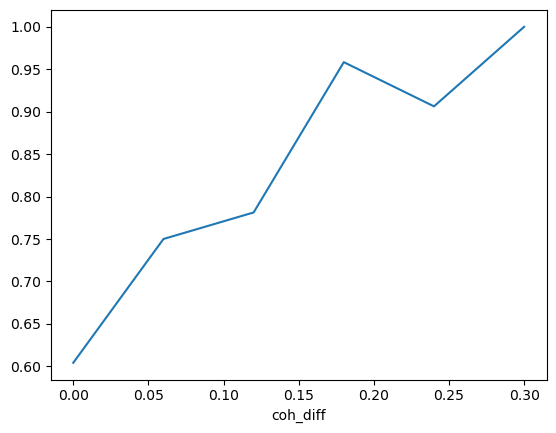

In [69]:
# let's look at performance as a function of coh_diff
df.groupby('coh_diff')['correct'].mean().plot()

<Axes: xlabel='coh_diff'>

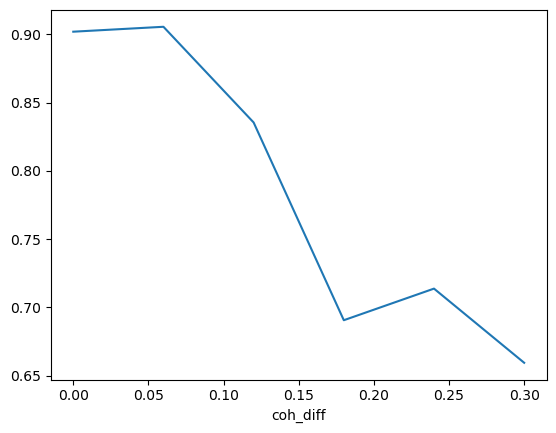

In [70]:
# how about rts
df.groupby('coh_diff')['rt'].mean().plot()

<Axes: xlabel='coh_diff'>

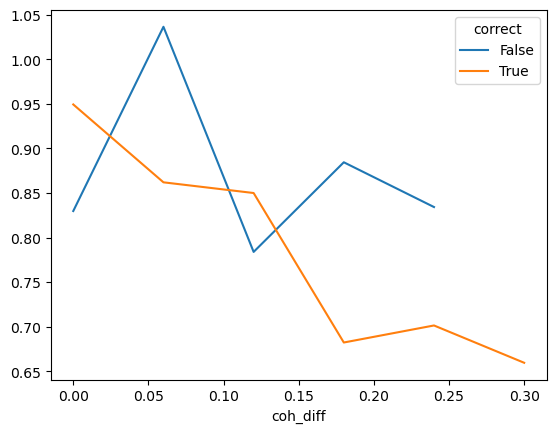

In [72]:
# you can group by more than one column
df.groupby(['coh_diff', 'correct'])['rt'].mean().unstack().plot()

In [79]:
# you can group by more than one column
df.groupby(['coh_diff', 'correct'])['rt'].mean()

coh_diff  correct
0.00      False      0.829746
          True       0.949310
0.06      False      1.036445
          True       0.861958
0.12      False      0.783893
          True       0.849955
0.18      False      0.884447
          True       0.682256
0.24      False      0.834226
          True       0.701371
0.30      True       0.659511
Name: rt, dtype: float64

In [121]:
# is there a speed bias?
df.groupby(['correct_resp'])['log_rt'].mean()

correct_resp
1   -0.323040
4   -0.277191
Name: log_rt, dtype: float64

In [120]:
# is there an accuracy bias?
df.groupby(['correct_resp'])['correct'].mean()

correct_resp
1    0.879032
4    0.733871
Name: correct, dtype: float64

## Assignment before next class

- Your SMILE experiment is due by Thursday next week.

### See you next week!!!